In [99]:
import sqlite3
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import datetime as dt
import matplotlib.dates as mdates
from PyAstronomy import pyasl

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [3]:
# Create the sqlite connection, print the names of the tables in the .db file
conn = sqlite3.connect('data/crime_census_weather_tod.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('violent_crimes',), ('property_crmes',), ('all_crimes',)]


In [4]:
conn = sqlite3.connect('data/crime_census_weather_tod.db')
df = pd.read_sql_query("SELECT * FROM all_crimes", conn)
#dfv = pd.read_sql_query("SELECT * FROM violent_crimes", conn)
#dfp = pd.read_sql_query("SELECT * FROM property_crmes", conn)
conn.close()

In [5]:
df.head(5)

,level_0,BLOCK_GROUP,year,month,day,tod,offensegroup,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,index,TotalPop,TPopMargin,UnWgtSampleCtPop,PerCapitaIncome,PerCapIncMargin,MedianHouseholdInc,MedHouseholdIncMargin,MedianAge,MedianAgeMargin,HousingUnits,HousingUnitsMargin,UnweightedSampleHousingUnits,State,County,Tract,BlockGroup,census_year
0,0,000100 1,2007,9,10,Morning,1,85.76,0.52,69.99,0.67,0.0,0.0,1015.85,81.95,3.0,6.59,321.0,3.72,1.19,00010012007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
1,1,000100 1,2007,12,1,Afternoon,1,39.42,0.15,11.99,0.29,0.0,0.0,1031.59,41.80,1.0,6.44,338.0,11.12,3.97,00010012007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
2,2,000100 1,2008,4,27,Afternoon,1,55.49,1.00,51.42,0.86,0.0,0.0,1021.27,55.49,4.0,4.17,46.0,6.77,2.89,00010012008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
3,3,000100 1,2008,5,1,Evening,1,67.75,0.13,50.17,0.53,0.0,0.0,1016.06,67.75,1.0,6.64,129.0,4.91,1.91,00010012008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
4,4,000100 1,2008,6,1,Evening,1,78.18,0.36,55.85,0.46,0.0,0.0,1008.60,78.18,0.0,6.37,283.0,9.99,3.94,00010012008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None


In [6]:
df.dtypes

level_0                           int64
BLOCK_GROUP                      object
year                             object
month                            object
day                              object
tod                              object
offensegroup                      int64
apparent_temp                   float64
cloud_cover                     float64
dew_point                       float64
humidity                        float64
percip_intensity                float64
percip_probability              float64
pressure                        float64
temperature                     float64
uv_index                        float64
visibility                      float64
wind_bearing                    float64
wind_gust                       float64
wind_speed                      float64
index                            object
TotalPop                        float64
TPopMargin                      float64
UnWgtSampleCtPop                float64
PerCapitaIncome                 float64


In [7]:
df.isnull().sum(axis = 0)

level_0                              0
BLOCK_GROUP                          0
year                                 0
month                                0
day                                  0
tod                                  0
offensegroup                         0
apparent_temp                       72
cloud_cover                         97
dew_point                           89
humidity                            89
percip_intensity                    99
percip_probability                  99
pressure                            76
temperature                         72
uv_index                            85
visibility                          88
wind_bearing                     11900
wind_gust                          264
wind_speed                          73
index                                0
TotalPop                        171120
TPopMargin                      171120
UnWgtSampleCtPop                171120
PerCapitaIncome                 171120
PerCapIncMargin          

### For this notebook, and preliminary modeling - removing null values in the dataset

In [8]:
df1 = df[df.TotalPop.notnull()]
df2 = df1[df.wind_bearing.notnull()]
df3 = df2[df.wind_gust.notnull()]

/Users/DanSchorer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/DanSchorer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df3.isnull().sum(axis = 0)

level_0                         0
BLOCK_GROUP                     0
year                            0
month                           0
day                             0
tod                             0
offensegroup                    0
apparent_temp                   0
cloud_cover                     0
dew_point                       0
humidity                        0
percip_intensity                0
percip_probability              0
pressure                        0
temperature                     0
uv_index                        0
visibility                      0
wind_bearing                    0
wind_gust                       0
wind_speed                      0
index                           0
TotalPop                        0
TPopMargin                      0
UnWgtSampleCtPop                0
PerCapitaIncome                 0
PerCapIncMargin                 0
MedianHouseholdInc              0
MedHouseholdIncMargin           0
MedianAge                       0
MedianAgeMargi

In [10]:
df4 = df3.astype({'year': int,
                  'month': int,
                  'day': int,
                  'BLOCK_GROUP': str})

In [11]:
df4.dtypes

level_0                           int64
BLOCK_GROUP                      object
year                              int64
month                             int64
day                               int64
tod                              object
offensegroup                      int64
apparent_temp                   float64
cloud_cover                     float64
dew_point                       float64
humidity                        float64
percip_intensity                float64
percip_probability              float64
pressure                        float64
temperature                     float64
uv_index                        float64
visibility                      float64
wind_bearing                    float64
wind_gust                       float64
wind_speed                      float64
index                            object
TotalPop                        float64
TPopMargin                      float64
UnWgtSampleCtPop                float64
PerCapitaIncome                 float64


In [12]:
dff = df4[df4.year > 2012]

In [13]:
dff['year'].unique()

array([2013, 2014, 2015, 2016, 2017])

In [15]:
df['tod'].unique()

array(['Morning', 'Afternoon', 'Evening', 'Night', 'Midnight',
       'Early Morning', ''], dtype=object)

In [102]:
df['BLOCK_GROUP'].nunique()

450

In [16]:
dff.head(5)

,level_0,BLOCK_GROUP,year,month,day,tod,offensegroup,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,index,TotalPop,TPopMargin,UnWgtSampleCtPop,PerCapitaIncome,PerCapIncMargin,MedianHouseholdInc,MedHouseholdIncMargin,MedianAge,MedianAgeMargin,HousingUnits,HousingUnitsMargin,UnweightedSampleHousingUnits,State,County,Tract,BlockGroup,census_year
139,139,000100 1,2013,1,10,Early Morning,1,44.43,0.34,27.77,0.52,0.0000,0.00,1031.65,44.43,0.0,5.77,330.0,2.49,0.74,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013
140,140,000100 1,2013,1,30,Night,1,57.28,0.98,55.38,0.93,0.1323,0.99,996.10,57.28,0.0,3.57,110.0,4.92,1.33,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013
141,141,000100 1,2013,2,4,Evening,1,32.68,0.91,18.64,0.56,0.0000,0.00,1015.17,32.68,0.0,6.67,161.0,1.22,0.36,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013
142,142,000100 1,2013,2,14,Afternoon,1,43.85,0.00,28.66,0.55,0.0053,0.22,1016.32,43.85,4.0,6.54,305.0,6.58,2.49,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013
143,143,000100 1,2013,3,8,Afternoon,1,44.84,0.72,27.55,0.44,0.0000,0.00,1020.88,48.26,1.0,6.40,339.0,16.90,7.55,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013


In [17]:
dff.shape

(157040, 38)

In [18]:
dff = dff.reset_index(drop=True)

### May be useful to have an actual date feature for possible use

In [20]:
for index, row in dff.iterrows():
    hour = 0
    minu= 0
    if dff['tod'][index] == 'Midnight':
        hour = 1
        minu= 30
    elif dff['tod'][index] == 'Early Morning':
        hour = 4
        minu= 30
    elif dff['tod'][index] == 'Morning':
        hour = 9
        minu = 0
    elif dff['tod'][index] == 'Afternoon':
        hour = 15
        minu = 0
    elif dff['tod'][index] == 'Evening':
        hour = 17
        minu = 30
    elif dff['tod'][index] == 'Night':
        hour = 22
        minu = 30
        
    dff.loc[index,'Date'] = dt.datetime(dff['year'][index], dff['month'][index], dff['day'][index], hour, minu, 0)
    

### Adding weekday as a feature as well

In [21]:
for index, row in dff.iterrows():
    dff.loc[index,'Weekday'] = dff['Date'][index].weekday()

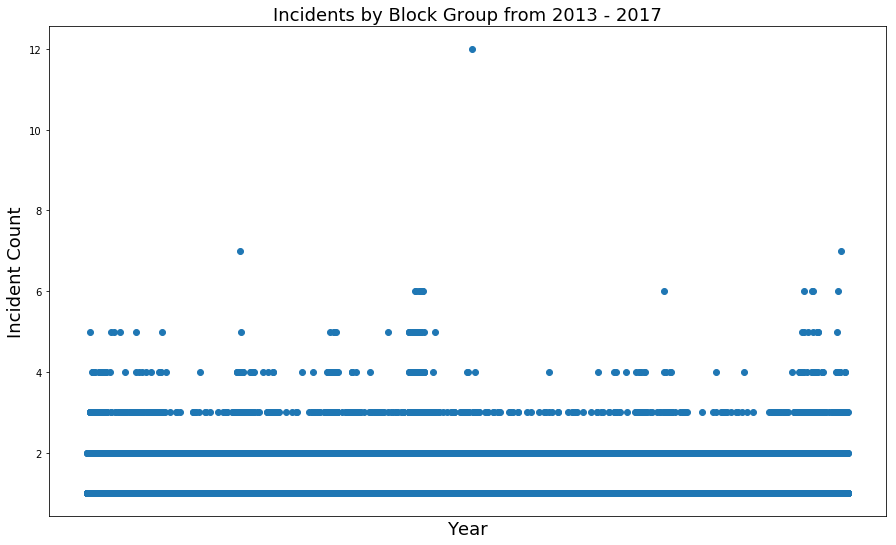

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(dff.offensegroup.index, dff.offensegroup)

# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# Add the title to the graph
plt.title('Incidents by Block Group from 2013 - 2017', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('Incident Count', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()

In [101]:
dff.head(50)

,level_0,BLOCK_GROUP,year,month,day,offensegroup,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,index,TotalPop,TPopMargin,UnWgtSampleCtPop,PerCapitaIncome,PerCapIncMargin,MedianHouseholdInc,MedHouseholdIncMargin,MedianAge,MedianAgeMargin,HousingUnits,HousingUnitsMargin,UnweightedSampleHousingUnits,State,County,Tract,BlockGroup,census_year,Date,tod_Afternoon,tod_Early Morning,tod_Evening,tod_Midnight,tod_Morning,tod_Night,wkday_0.0,wkday_1.0,wkday_2.0,wkday_3.0,wkday_4.0,wkday_5.0,wkday_6.0
0,139,000100 1,2013,1,10,1,44.430,0.340,27.770,0.520,0.0000,0.00,1031.65,44.430,0.0,5.77,330.0,2.49,0.740,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-01-10 04:30:00,0,1,0,0,0,0,0,0,0,1,0,0,0
1,140,000100 1,2013,1,30,1,57.280,0.980,55.380,0.930,0.1323,0.99,996.10,57.280,0.0,3.57,110.0,4.92,1.330,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-01-30 22:30:00,0,0,0,0,0,1,0,0,1,0,0,0,0
2,141,000100 1,2013,2,4,1,32.680,0.910,18.640,0.560,0.0000,0.00,1015.17,32.680,0.0,6.67,161.0,1.22,0.360,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-02-04 17:30:00,0,0,1,0,0,0,1,0,0,0,0,0,0
3,142,000100 1,2013,2,14,1,43.850,0.000,28.660,0.550,0.0053,0.22,1016.32,43.850,4.0,6.54,305.0,6.58,2.490,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-02-14 15:00:00,1,0,0,0,0,0,0,0,0,1,0,0,0
4,143,000100 1,2013,3,8,1,44.840,0.720,27.550,0.440,0.0000,0.00,1020.88,48.260,1.0,6.40,339.0,16.90,7.550,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-03-08 15:00:00,1,0,0,0,0,0,0,0,0,0,1,0,0
5,144,000100 1,2013,3,19,1,57.090,0.200,35.080,0.430,0.0000,0.00,1006.70,57.090,4.0,6.27,261.0,12.19,4.200,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-03-19 15:00:00,1,0,0,0,0,0,0,1,0,0,0,0,0
6,145,000100 1,2013,3,19,1,36.650,1.000,34.970,0.940,0.0000,0.00,1008.87,36.650,0.0,4.64,294.0,2.05,0.670,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-03-19 09:00:00,0,0,0,0,1,0,0,1,0,0,0,0,0
7,146,000100 1,2013,4,3,1,41.220,0.050,11.290,0.260,0.0000,0.00,1026.44,43.770,0.0,6.64,346.0,12.73,4.560,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-04-03 17:30:00,0,0,1,0,0,0,0,0,1,0,0,0,0
8,147,000100 1,2013,4,11,1,82.130,0.110,58.430,0.450,0.0000,0.00,1010.66,82.110,8.0,6.52,144.0,6.63,1.940,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-04-11 15:00:00,1,0,0,0,0,0,0,0,0,1,0,0,0
9,149,000100 1,2013,5,8,1,61.690,0.940,54.940,0.790,0.0157,0.55,1014.60,61.690,3.0,6.55,191.0,5.77,1.240,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-05-08 15:00:00,1,0,0,0,0,0,0,0,1,0,0,0,0


### Decimal year likely not needed, but code below will do the trick

In [ ]:
'''
# Convert July 2nd, 1998, 12:30:59 into decimal
# representation
d = dt.datetime(1998,7,2,23,30,59)

# Obtain float representation of decimal year
decy = pyasl.decimalYear(d)
print("Decimal representation: ", decy)

for index, row in df2.iterrows():
    df2.loc[index,'Start_DecimalYear'] = pyasl.decimalYear(dt.datetime(df2['Start_Year'][index],
                                                         df2['Start_Month'][index],
                                                         df2['Start_Day'][index],
                                                         df2['Start_Hour'][index],
                                                         df2['Start_Minute'][index],
                                                         df2['Start_Second'][index]))
'''

### Creating dummy variables for categorical variables

In [24]:
#dff1 = pd.get_dummies(dff, prefix={'tod': 'tod'})
dff = pd.get_dummies(dff, prefix=['tod'], columns=['tod'])

In [25]:
dff = pd.get_dummies(dff, prefix=['wkday'], columns=['Weekday'])

In [26]:
dff.head()

,level_0,BLOCK_GROUP,year,month,day,offensegroup,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,index,TotalPop,TPopMargin,UnWgtSampleCtPop,PerCapitaIncome,PerCapIncMargin,MedianHouseholdInc,MedHouseholdIncMargin,MedianAge,MedianAgeMargin,HousingUnits,HousingUnitsMargin,UnweightedSampleHousingUnits,State,County,Tract,BlockGroup,census_year,Date,tod_Afternoon,tod_Early Morning,tod_Evening,tod_Midnight,tod_Morning,tod_Night,wkday_0.0,wkday_1.0,wkday_2.0,wkday_3.0,wkday_4.0,wkday_5.0,wkday_6.0
0,139,000100 1,2013,1,10,1,44.43,0.34,27.77,0.52,0.0000,0.00,1031.65,44.43,0.0,5.77,330.0,2.49,0.74,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-01-10 04:30:00,0,1,0,0,0,0,0,0,0,1,0,0,0
1,140,000100 1,2013,1,30,1,57.28,0.98,55.38,0.93,0.1323,0.99,996.10,57.28,0.0,3.57,110.0,4.92,1.33,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-01-30 22:30:00,0,0,0,0,0,1,0,0,1,0,0,0,0
2,141,000100 1,2013,2,4,1,32.68,0.91,18.64,0.56,0.0000,0.00,1015.17,32.68,0.0,6.67,161.0,1.22,0.36,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-02-04 17:30:00,0,0,1,0,0,0,1,0,0,0,0,0,0
3,142,000100 1,2013,2,14,1,43.85,0.00,28.66,0.55,0.0053,0.22,1016.32,43.85,4.0,6.54,305.0,6.58,2.49,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-02-14 15:00:00,1,0,0,0,0,0,0,0,0,1,0,0,0
4,143,000100 1,2013,3,8,1,44.84,0.72,27.55,0.44,0.0000,0.00,1020.88,48.26,1.0,6.40,339.0,16.90,7.55,00010012013,1240.0,306.0,67.0,109147.0,30185.0,104083.0,29431.0,37.0,7.2,743.0,144.0,40.0,11.0,1.0,000100,1,2013,2013-03-08 15:00:00,1,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
dff.shape

(157040, 51)

In [28]:
sample = dff[dff.year == 2017]

In [30]:
sample1 = sample[['offensegroup',
                  'apparent_temp',
                  'cloud_cover',
                  'dew_point',
                  'humidity',
                  'percip_intensity',
                  'percip_probability',
                  'pressure',
                  'temperature',
                  'uv_index',
                  'visibility',
                  'wind_bearing',
                  'wind_gust',
                  'wind_speed',
                  'TotalPop',
                  'PerCapitaIncome',
                  'MedianHouseholdInc',
                  'MedianAge',
                  'HousingUnits']]
'''             
                  'tod_Evening',
                  'tod_Midnight',
                  'tod_Morning',
                  'tod_Night',
                  'tod_Afternoon',
                  'tod_Early Morning',
                  'wkday_0.0',
                  'wkday_1.0',
                  'wkday_2.0',
                  'wkday_3.0',
                  'wkday_4.0',
                  'wkday_5.0',
                  'wkday_6.0']]
'''

"             \n                  'tod_Evening',\n                  'tod_Midnight',\n                  'tod_Morning',\n                  'tod_Night',\n                  'tod_Afternoon',\n                  'tod_Early Morning',\n                  'wkday_0.0',\n                  'wkday_1.0',\n                  'wkday_2.0',\n                  'wkday_3.0',\n                  'wkday_4.0',\n                  'wkday_5.0',\n                  'wkday_6.0']]\n"

In [77]:
sample1.tail(50)

,offensegroup,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,TotalPop,PerCapitaIncome,MedianHouseholdInc,MedianAge,HousingUnits
156990,1,69.11,0.17,50.450,0.51,0.0000,0.00,1026.910,69.11,0.0,7.940,169.0,0.22,0.020,1686.0,19928.0,32250.0,52.7,574.0
156991,1,62.92,0.44,39.740,0.42,0.0000,0.00,1007.140,62.92,3.0,8.720,294.0,4.24,0.730,1686.0,19928.0,32250.0,52.7,574.0
156992,1,52.23,0.69,39.940,0.63,0.0000,0.00,1011.880,52.23,2.0,8.540,299.0,10.67,4.040,1686.0,19928.0,32250.0,52.7,574.0
156993,1,50.98,0.00,44.380,0.78,0.0000,0.00,1016.040,50.98,0.0,7.890,173.0,1.65,0.710,1686.0,19928.0,32250.0,52.7,574.0
156994,1,54.86,0.00,46.330,0.73,0.0000,0.00,1017.110,54.86,0.0,7.680,179.0,2.34,0.650,1686.0,19928.0,32250.0,52.7,574.0
156995,1,62.46,0.57,59.190,0.89,0.0000,0.00,1007.240,62.32,0.0,8.180,131.0,2.28,0.560,1686.0,19928.0,32250.0,52.7,574.0
156996,1,41.31,0.07,35.810,0.81,0.0000,0.00,1024.090,41.31,0.0,9.990,56.0,0.37,0.210,1686.0,19928.0,32250.0,52.7,574.0
156997,1,62.06,0.40,53.290,0.73,0.0000,0.00,1022.370,62.06,0.0,8.540,5.0,5.62,1.970,1686.0,19928.0,32250.0,52.7,574.0
156998,1,60.08,0.50,50.870,0.72,0.0000,0.00,1022.990,60.08,0.0,8.120,16.0,6.13,1.870,1686.0,19928.0,32250.0,52.7,574.0
156999,1,47.31,0.06,40.300,0.76,0.0000,0.00,1026.250,47.31,0.0,8.870,32.0,2.29,1.200,1686.0,19928.0,32250.0,52.7,574.0


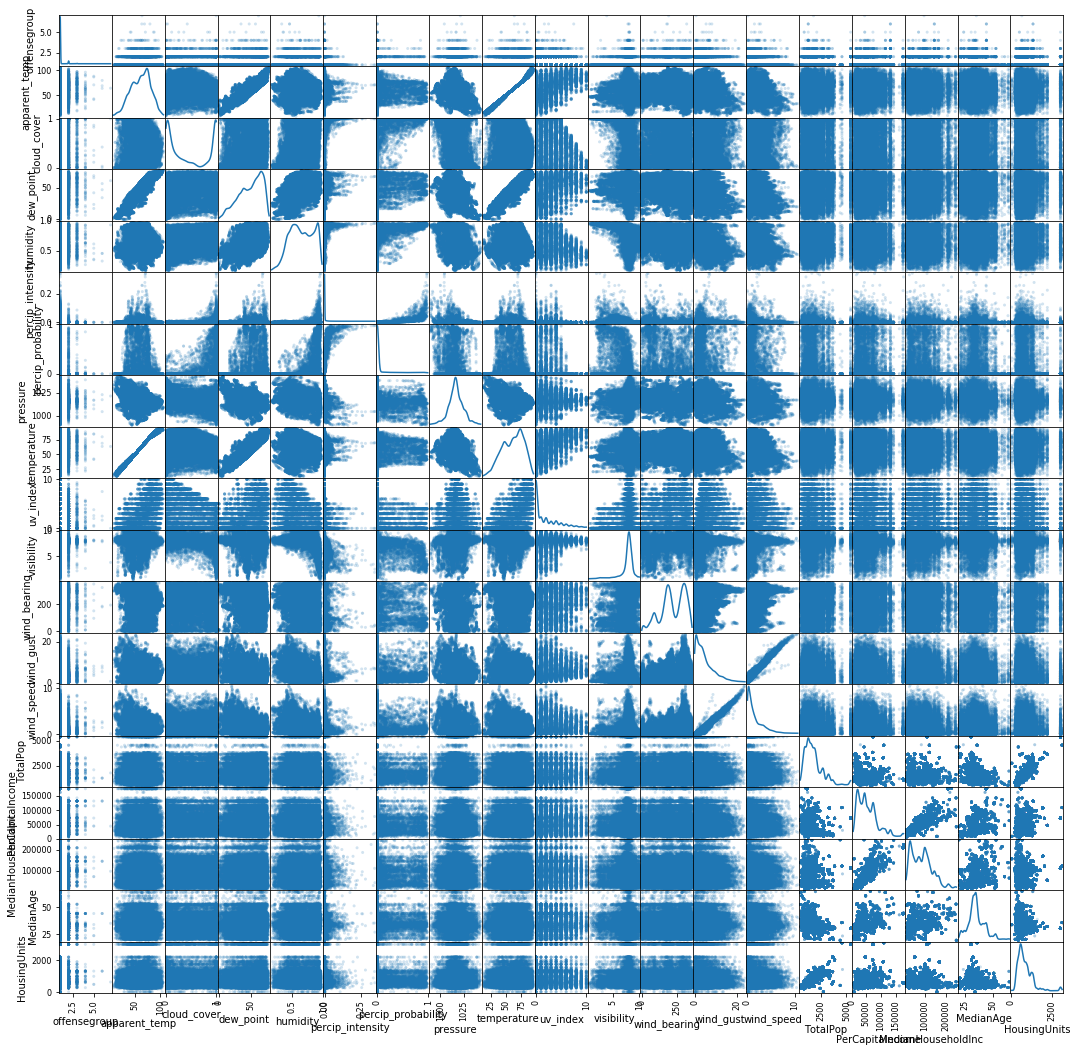

In [32]:
scatter_matrix(sample1, alpha=0.2, figsize=(18,18), diagonal='kde')
plt.show()

In [ ]:
scatter_matrix(sample1[['']], alpha=0.2, figsize=(18,18), diagonal='kde')
plt.show()

In [41]:
# calculate spearman's correlation
coef, p = spearmanr(dff.offensegroup, dff.percip_intensity)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.014
Samples are correlated (reject H0) p=0.000


In [71]:
# calculate spearman's correlation
coef, p = spearmanr(dff.offensegroup, dff.wind_speed)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.025
Samples are correlated (reject H0) p=0.000


In [72]:
# calculate spearman's correlation
coef, p = spearmanr(dff.offensegroup, dff.TotalPop)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.032
Samples are correlated (reject H0) p=0.000


In [73]:
# calculate spearman's correlation
coef, p = spearmanr(dff.offensegroup, dff.MedianHouseholdInc)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.075
Samples are correlated (reject H0) p=0.000


In [43]:
dfml = sample[['offensegroup',
                  'apparent_temp',
                  'cloud_cover',
                  'dew_point',
                  'humidity',
                  'percip_intensity',
                  'percip_probability',
                  'pressure',
                  'temperature',
                  'uv_index',
                  'visibility',
                  'wind_bearing',
                  'wind_gust',
                  'wind_speed',
                  'TotalPop',
                  'PerCapitaIncome',
                  'MedianHouseholdInc',
                  'MedianAge',
                  'HousingUnits',            
                  'tod_Evening',
                  'tod_Midnight',
                  'tod_Morning',
                  'tod_Night',
                  'tod_Afternoon',
                  'tod_Early Morning',
                  'wkday_0.0',
                  'wkday_1.0',
                  'wkday_2.0',
                  'wkday_3.0',
                  'wkday_4.0',
                  'wkday_5.0',
                  'wkday_6.0']]

In [44]:
y = dfml.offensegroup

In [45]:
X = dfml[['apparent_temp',
          'cloud_cover',
          'dew_point',
          'humidity',
          'percip_intensity',
          'percip_probability',
          'pressure',
          'temperature',
          'uv_index',
          'visibility',
          'wind_bearing',
          'wind_gust',
          'wind_speed',
          'TotalPop',
          'PerCapitaIncome',
          'MedianHouseholdInc',
          'MedianAge',
          'HousingUnits',            
          'tod_Evening',
          'tod_Midnight',
          'tod_Morning',
          'tod_Night',
          'tod_Afternoon',
          'tod_Early Morning',
          'wkday_0.0',
          'wkday_1.0',
          'wkday_2.0',
          'wkday_3.0',
          'wkday_4.0',
          'wkday_5.0',
          'wkday_6.0']]

In [59]:
X.describe()

,apparent_temp,cloud_cover,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,TotalPop,PerCapitaIncome,MedianHouseholdInc,MedianAge,HousingUnits,tod_Evening,tod_Midnight,tod_Morning,tod_Night,tod_Afternoon,tod_Early Morning,wkday_0.0,wkday_1.0,wkday_2.0,wkday_3.0,wkday_4.0,wkday_5.0,wkday_6.0
count,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000,27987.000000
mean,61.441712,0.482182,0.650242,0.002257,0.056084,1016.789486,61.027368,1.704350,7.717274,204.384699,4.728677,1.539994,1740.323436,52599.482867,85687.709615,35.029832,825.752992,0.179583,0.079037,0.215814,0.125594,0.358202,0.041769,0.144424,0.141316,0.142173,0.139136,0.151678,0.142352,0.138922
std,18.444192,0.369097,0.183477,0.012983,0.181959,7.511847,16.989059,2.306728,1.276345,97.935047,4.143281,1.603479,869.407064,31572.320724,47177.365807,6.943996,458.269744,0.383847,0.269801,0.411394,0.331397,0.479480,0.200065,0.351526,0.348353,0.349234,0.346095,0.358714,0.349417,0.345871
min,6.860000,0.000000,0.170000,0.000000,0.000000,989.390000,12.700000,0.000000,0.390000,0.000000,0.010000,0.003333,463.000000,5538.000000,12649.000000,19.600000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.470000,0.110000,0.500000,0.000000,0.000000,1012.390000,47.780000,0.000000,7.600000,135.000000,1.510000,0.340000,1150.000000,26526.000000,44537.000000,30.900000,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.960000,0.440000,0.640000,0.000000,0.000000,1016.480000,62.890000,0.000000,7.995000,205.500000,3.620000,0.960000,1542.000000,45654.000000,82408.000000,34.400000,726.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.190000,0.870000,0.810000,0.000000,0.000000,1021.220000,74.585000,3.000000,8.330000,292.000000,6.780000,2.260000,2080.000000,72428.000000,115568.000000,38.700000,1010.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,106.130000,1.000000,0.980000,0.343200,0.990000,1042.960000,94.590000,10.000000,10.000000,359.000000,24.010000,10.650000,5407.000000,175725.000000,247222.000000,64.600000,3093.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
X = X.drop(['dew_point'], axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [70]:
model = MultinomialNB()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('MultinomialNB')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Random Forest model
Mean squared error = 4.378
R2 score = -47.248


In [94]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)


print('Random Forest model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
#print('Accuracy score = %0.3f' % accuracy_score(expected, predicted))

/Users/DanSchorer/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest model
Mean squared error = 0.088
R2 score = 0.028


In [83]:
model = OneClassSVM()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Random Forest model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

/Users/DanSchorer/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Random Forest model
Mean squared error = 4.379
R2 score = -47.267


In [105]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Random Forest model')
#print('Mean squared error = %0.3f' % mse(expected, predicted))
print('Accuracy score = %0.3f' % accuracy_score(expected, predicted))
#print('R2 score = %0.3f' % r2_score(expected, predicted))

Random Forest model
Accuracy score = 0.935


In [104]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)


print('Random Forest model')
#print('Mean squared error = %0.3f' % mse(expected, predicted))
#print('R2 score = %0.3f' % r2_score(expected, predicted))
print('Accuracy score = %0.3f' % accuracy_score(expected, predicted))
confusion_matrix(expected, predicted)

/Users/DanSchorer/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest model
Accuracy score = 0.939


array([[13111,    20,     2,     0,     0,     0,     0],
       [  725,    34,     1,     0,     0,     0,     0],
       [   72,     7,     0,     0,     0,     0,     0],
       [   16,     1,     1,     0,     0,     0,     0],
       [    1,     0,     0,     0,     0,     0,     0],
       [    2,     0,     0,     0,     0,     0,     0],
       [    1,     0,     0,     0,     0,     0,     0]])